# Step 3: Calculate water stress, water depletion, inter-annual variability, and seasonal variability

**********************************************
version 10

**********************************************
0. Arid and low water use
    - compare annual data to annual thresholds
    - apply annual classification to all monthly data

1. Water stress
    - monthly per gcm per scen: ww/ba; 
    - annual per gcm per scen: weight monthly average by monthly demand
    - set arid raw, score, cat, lab = 1, 5, -1, Arid and Low Water Use
    - when supply = 0, set cat = -5
2. Water depletion
    - monthly per gcm per scen: wn/ba; 
    - annual per gcm per scen: weight monthly average by monthly consumption
    - set arid raw, score, cat, lab = 1, 5, -1, Arid and Low Water Use
    - when supply = 0, set cat = -5
3. Interannual variability
    - monthly per gcm per scen: standard deviation of supply / average supply (stats calculated during temporal aggregation)
    - annual per gcm per scen: standard deviation of supply / average supply (stats calculated during temporal aggregation)
    - when supply = 0, set cat = -5
4. Seasonal variability
    - calculate standard deviation and average across months using monthly averages used in Interannual variability step 1
    - annual per gcm per scen: standard deviation of monthly supplies / average of monthly supplies 
    - when supply = 0, set cat = -5

In [7]:
import os, datetime
import geopandas as gpd
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

In [8]:
# PATHS!
# root
rootPATH = r'\Projections\Final_Data\Data'

# 1. Hydrobasin 6 
hy6PATH = os.path.join(rootPATH,  "shapes", "hybas_lev06_v1c_merged_fiona_V04.shp")

# 2. Country boundaries
ad0PATH = os.path.join(rootPATH,  "shapes", "gadm36_0.shp")

# 3. Supply demand data
# Final data based on Theil Sen Regression
sdPATH =  os.path.join(rootPATH, 'Aqueduct40', 'step2_temporal_aggregation', 'final', 'Aqueduct40_supplydemand_{}-exploded-additive.csv').format

# 4. Area
areaPATH =  os.path.join(rootPATH, "Aqueduct40", "util", "hybas_area.csv")
area = pd.read_csv(areaPATH, index_col = 'pfaf_id')
arPATH = os.path.join(rootPATH, 'Aqueduct40', 'step2_temporal_aggregation', 'working', 'step3_pool-deltas', 'area_delta.csv')
area2 = pd.read_csv(arPATH, index_col = 'pfaf_id')
# Global climate models
gcmFolders =  ['gfdl-esm4',
              'ipsl-cm6a-lr',
              'mpi-esm1-2-hr',
              'mri-esm2-0',
              'ukesm1-0-ll']

# Future scenarions
scenFolders = ['ssp126',
               'ssp370',
               'ssp585'
              ]

months = [str(x).zfill(2) for x in range(1,13)]

# Fix column names
baseline_inds = {'ws': 'bws', 'wd': 'bwd', 'iv': 'iav', 'sv': 'sev'}
baseline_typs = {'_r': '_raw', '_s': '_score', '_c': '_cat', '_l': '_label'}


area = pd.read_csv(areaPATH, index_col = 'pfaf_id')

# Indicators
outPATH = r'Projections\Final_Data\Data\Aqueduct40\step3_calculate_indicators'

# PCR-GLOBWB Indicators
inPATH = os.path.join(outPATH, 'working', 'Aqueduct40_indicators_{}-additive.csv').format
fnPATH = os.path.join(outPATH, 'final', 'Aqueduct40_indicators_{}-additive.csv').format


# Function to create category value from score for all indicators
def category(score, df_in):
    cat = 'cat'
    df_cat = np.floor(df_in[score]).to_frame(name = cat)
    df_cat[cat] = np.where(df_cat[cat] == 5, 4, df_cat[cat])
    return df_cat

def restructure_future(df_in, monthly):
    # Melt future dataframe
    df_melt = df_in.melt(ignore_index = False)
    # Explode column names into rows
    df_melt['dtype'] = df_melt['variable'].apply(lambda x: x.split("_")[0])
    df_melt['scen'] = df_melt['variable'].apply(lambda x: x.split("_")[1] +"_"+ x.split("_")[2])
    df_melt.dropna(subset = ['value'], inplace = True)
    # Pivot tables so data
    if monthly == True:
        df_pv = pd.pivot(data = df_melt.reset_index(), index = ['pfaf_id', 'period', 'month', 'scen'], values = 'value', columns = ['dtype'])
    else:
        df_pv = pd.pivot(data = df_melt.reset_index(), index = ['pfaf_id', 'period', 'scen'], values = 'value', columns = ['dtype'])
    return df_pv

# 3. Define Arid and low water use thresholds
aridThres = 0.03
lowuseThres = 0.012

def ws_score(r):
    if np.isnan(r):
        score = -9999
    elif r == -5:
        score = -5
    elif r == -9999:
        score = -9999
    else:
        score = ((np.log(r) - np.log(0.1))/np.log(2)) + 1
        score = min(score, 5)
        score = max(score, 0)
    return score

ws_labels = {
#     -5 : 'Zero Supply',
    -9999 : 'No Data',
    -1: 'Arid and Low Water Use',
    0: 'Low (<10%)',
    1: 'Low - Medium (10-20%)',
    2: 'Medium - High (20-40%)',
    3: 'High (40-80%)', 
    4: 'Extremely High (>80%)'
}

ws_fut_labels = {
#     -5 : 'Zero Supply',
    -9999 : 'No data',
    -1: 'Arid and low water use',
    0: 'Low (<10%)',
    1: 'Low-medium (10-20%)',
    2: 'Medium-high (20-40%)',
    3: 'High (40-80%)', 
    4: 'Extremely high (>80%)'
}

def wd_score(r):
    if np.isnan(r):
        score = -9999
    elif r == -5:
        score = -5
    elif r == -9999:
        score = -9999
    else:
        if r < 0.05:
            score = max(20*r, 0)
        elif r < 0.25:
            score = 5*r + 0.75
        else:
            score = min(5, r*4 + 1)
    return score


wd_labels = {
#     -5 : 'Zero Supply',
    -9999 : 'No Data',
    -1: 'Arid and Low Water Use',
    0: 'Low (<5%)',
    1: 'Low - Medium (5-25%)',
    2: 'Medium - High (25-50%)',
    3: 'High (50-75%)', 
    4: 'Extremely High (>75%)'
}

def iv_score(r):
    if np.isnan(r):
        score = -9999
    elif r == -9999:
        score = -9999
    else:
        score = r * 4
        score = min(5, score)
        score = max(0, score)
    return score


iv_labels = {
#     -5 : 'Zero Supply',
    -9999 : 'No Data',
    0: 'Low (<0.25)',
    1: 'Low - Medium (0.25-0.50)',
    2: 'Medium - High (0.50-0.75)',
    3: 'High (0.75-1.00)', 
    4: 'Extremely High (>1.00)'
}

def sv_score(r):
    if np.isnan(r):
        score = -9999
    elif r == -9999:
        score = -9999
    else:
        score = r * 3
        score = min(5, score)
        score = max(0, score)
    return score

def ba_labels(r):
    if np.isnan(r):
        lab = 'No Data'
    elif r < 1:
        lab = '< 1 cm'
    elif r < 3:
        lab = '1-3 cm'
    elif r < 10:
        lab = '3-10 cm'
    elif r < 30:
        lab = '10-30 cm'
    elif r < 100:
        lab = '30-100 cm'
    elif r < 300:
        lab = '100-300 cm'
    elif r < 1000:
        lab = '300-1000 cm'
    else:
        lab = '>1000 cm'
    return lab

def ww_labels(r):
    if np.isnan(r):
        lab = 'No Data'
    elif r < 1:
        lab = '< 1 cm'
    elif r < 3:
        lab = '1-3 cm'
    elif r < 10:
        lab = '3-10 cm'
    elif r < 30:
        lab = '10-30 cm'
    else:
        lab = '>30 cm'
    return lab

sv_labels = {
#     -5 : 'Zero Supply',
    -9999 : 'No Data',
    0: 'Low (<0.33)',
    1: 'Low - Medium (0.33-0.66)',
    2: 'Medium - High (0.66-1.00)',
    3: 'High (1.00-1.33)', 
    4: 'Extremely High (>1.33)'
}

ssp_code = {
    'hist': 'hist',
    'ssp126': 'opt',
    'ssp370': 'bau',
    'ssp585': 'pes'
}


def cov_score(r):
    if r < 20:
        score = 0
    elif r < 40:
        score = 1
    else:
        score = 2
    return score

def change_sd_score(r):
    if np.isnan(r):
        score = -9999
    elif r == -9999:
        score = -9999
    elif r <= np.power(2, -6/8):
        score = -3
    elif r <= np.power(2, -4/8):
        score = -2
    elif r <= np.power(2, -2/8):
        score = -1
    elif r <= np.power(2, 2/8):
        score = 0
    elif r <= np.power(2, 4/8):
        score = 1
    elif r <= np.power(2, 6/8):
        score = 2
    else:
        score = 3   
    return score

def change_ws_score(r):
    if np.isnan(r):
        score = -9999
    elif r == -9999:
        score = -9999
    elif r <= np.power(2, -6/4):
        score = -3
    elif r <= np.power(2, -4/4):
        score = -2
    elif r <= np.power(2, -2/4):
        score = -1
    elif r <= np.power(2, 2/4):
        score = 0
    elif r <= np.power(2, 4/4):
        score = 1
    elif r <= np.power(2, 6/4):
        score = 2
    else:
        score = 3   
    return score

def change_va_score(r):
    if np.isnan(r):
        score = -9999
    elif r == -9999:
        score = -9999
    elif r <= np.power(2, -8/16):
        score = -3
    elif r <= np.power(2, -4/16):
        score = -2
    elif r <= np.power(2, -2/16):
        score = -1
    elif r <= np.power(2, 2/16):
        score = 0
    elif r <= np.power(2, 4/16):
        score = 1
    elif r <= np.power(2, 8/16):
        score = 2
    else:
        score = 3   
    return score

change_sd_labels = {
    -9999 : 'No Data',
    -3: '1.7x or greater decrease',
    -2: '1.4x decrease',
    -1: '1.2x decrease',
    0: 'Near normal',
    1: '1.2x increase',
    2: '1.4x increase',
    3: '1.7x or greater increase',
}

change_ws_labels = {
    -9999 : 'No Data',
    -3: '2.8x or greater decrease',
    -2: '2.0x decrease',
    -1: '1.4x decrease',
    0: 'Near normal',
    1: '1.4xincrease',
    2: '2.0x increase',
    3: '2.8x or greater increase',
}

change_va_labels = {
    -9999 : 'No Data',
    -3: '1.3x or greater decrease',
    -2: '1.2x decrease',
    -1: '1.1x decrease',
    0: 'Near normal',
    1: '1.1x increase',
    2: '1.2x increase',
    3: '1.3x or greater increase',
}

# 1. Read in data

In [5]:
df_m = pd.read_csv(sdPATH('monthly'), index_col = ['pfaf_id', 'period', 'month', 'scen'])
df_y = pd.read_csv(sdPATH('annual'), index_col = ['pfaf_id', 'period', 'scen'])

# 2. Calculate monthly indicators
## Stress and Depletion 
based on final suppy and demand data

## Variability
based on statistics from temporal aggregation

In [6]:
# - - - -  CALCULATE RAW - - - - - #
df_m['ws_r'] = df_m['bcr-ww'].divide(df_m['bcr-ba'])
df_m['wd_r'] = df_m['bcr-wn'].divide(df_m['bcr-ba'])
df_m['iv_r'] = df_m['std-ba'].divide(df_m['avg-ba'])

# When ba = 0, set raw = 9999 (or to -9999 for interannual variablility)
df_m['ws_r'] = df_m['ws_r'].mask(df_m['bcr-ba'] == 0, 9999)
df_m['wd_r'] = df_m['wd_r'].mask(df_m['bcr-ba'] == 0, 9999)
df_m['iv_r'].replace(np.nan, -9999, inplace = True)

# When ba is close to 0, and below 1/2 the monthly threshold, set to 9999
# This keeps very large WS values at bay (ie, dividing by a really small number)
df_m['ws_r'] = df_m['ws_r'].mask(df_m['flx2-ba'] == 1, 9999)
df_m['wd_r'] = df_m['wd_r'].mask(df_m['flx2-ba'] == 1, 9999)

# When ww is close to 0, and below 1/2 the monthly threshold, set to 0
# This keeps very large WS values at bay (ie, dividing by a really small number)
# df_m['ws_r'] = df_m['ws_r'].mask(df_m['flx2-ww'] == 1, 0)
# df_m['wd_r'] = df_m['wd_r'].mask(df_m['flx2-ww'] == 1, 0)

# Set arid raw value = 1
df_m['ws_r'] = df_m['ws_r'].mask(df_m['ar'] == 1, 1)
df_m['wd_r'] = df_m['wd_r'].mask(df_m['ar'] == 1, 1)

# - - - -  CALCULATE SCORES - - - - - #
df_m['ws_s'] = df_m['ws_r'].apply(lambda x: ws_score(x))
df_m['wd_s'] = df_m['wd_r'].apply(lambda x: wd_score(x))
df_m['iv_s'] = df_m['iv_r'].apply(lambda x: iv_score(x))
# Set arid score value = 5
df_m['ws_s'] = df_m['ws_s'].mask(df_m['ar']  == 1, 5)
df_m['wd_s'] = df_m['wd_s'].mask(df_m['ar']  == 1, 5)

# - - - -  CALCULATE CATEGORY - - - - - #
df_m['ws_c'] = category(score = 'ws_s', df_in = df_m)['cat']
df_m['wd_c'] = category(score = 'wd_s', df_in = df_m)['cat']
df_m['iv_c'] = category(score = 'iv_s', df_in = df_m)['cat']

# Set arid cat value = -1
df_m['ws_c'] = df_m['ws_c'].mask(df_m['ar']  == 1, -1)
df_m['wd_c'] = df_m['wd_c'].mask(df_m['ar']  == 1, -1)

# - - - -  CALCULATE LABEL - - - - - #
df_m['ws_l'] = df_m['ws_c'].map(ws_labels)
df_m['wd_l'] = df_m['wd_c'].map(wd_labels)
df_m['iv_l'] = df_m['iv_c'].map(iv_labels)

### View distribution of categories

<AxesSubplot:>

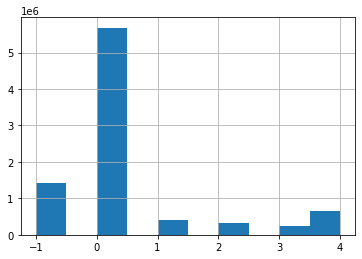

In [8]:
df_m['ws_c'].hist()

<AxesSubplot:>

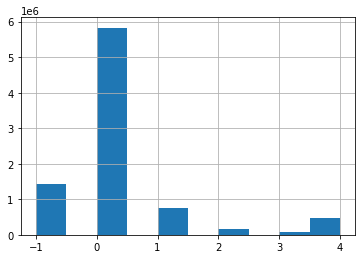

In [9]:
df_m['wd_c'].hist()

<AxesSubplot:>

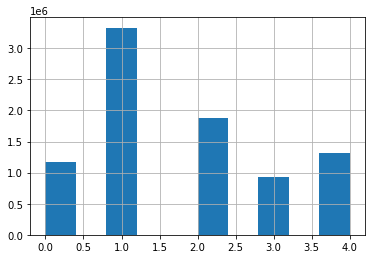

In [10]:
df_m['iv_c'][df_m['iv_c'] >= 0].hist()

In [11]:
df_m.to_csv(inPATH('monthly-exploded'))

In [12]:
# Read in monthly data created in step 2
df_mf = pd.read_csv(inPATH('monthly-exploded'), index_col = ['pfaf_id', 'period', 'month'])
# Only using baseline monthly data. Drop all other years/scenarios
df_mf = df_mf[df_mf.scen == 'baseline_hist']
# Drop non-indicator data
simple_ind_cols = ['{}_{}'.format(i, s) for i in ['ws', 'wd', 'iv'] for s in ['r', 's', 'c', 'l']]
df_mf = df_mf.filter(simple_ind_cols)
# # Rename columns using Aqueduct naming structure. 
ind_cols = [baseline_inds.get(x[0:2]) + baseline_typs.get(x[2:]) for x in df_mf.columns]
df_mf.columns = ind_cols
df_mf.index.names = ['pfaf_id', 'year', 'month']

In [13]:
# Save results in row format
df_mf.to_csv(fnPATH('monthly'))

# 3. Calculate annual indicators

## Stress and Depletion 
based on weighted averages of monthly data

## Variability
based on statistics from temporal aggregation

In [23]:
df_mm = pd.read_csv(inPATH('monthly-exploded'), index_col = ['pfaf_id', 'period', 'month', 'scen'])
# - - - -  CALCULATE RAW STRESS AND DEPLETION - - - - - #
# Create copy of monthly data, only keeping select fields
df_ma = df_mm.filter(['bcr-ww', 'bcr-wn', 'ws_r', 'wd_r'])
# Merge monthly data with annual totals of demand and consumption
df_ma = pd.merge(df_ma.reset_index(), df_y.filter(['bcr-ww', 'bcr-wn']), how = 'left', left_on = ['pfaf_id', 'period', 'scen'], right_index = True, suffixes = ['_m', '_y'])
# # Some catchments experience a few months with no supply (raw = 9999). 
# Left untouched, this will create a strange raw vale (> 1 but < 9999)
# For catchments with at least 6 months no supply, set annual to 9999 (will do this to the annual data below)
# For all others, set 9999 = 2 (arbitary high number to use when averaging)
df9999 = df_ma[df_ma.ws_r == 9999].groupby(['pfaf_id', 'period', 'scen'])['month'].count()
nosupply_idx = df9999.index[df9999 >=6] # ID for annual catchments to set at 9999 (at least 6 months of no supply)
df_ma['ws_r'] = df_ma['ws_r'].mask(df_ma['ws_r'] == 9999, 2)
df_ma['wd_r'] = df_ma['wd_r'].mask(df_ma['wd_r'] == 9999, 2)

# Create weight (percentage of annual demand per month. 
df_ma['ws_w'] =  (df_ma['bcr-ww_m'].divide(df_ma['bcr-ww_y']))
df_ma['wd_w'] =  (df_ma['bcr-wn_m'].divide(df_ma['bcr-wn_y']))
# If no demand, set to 0)
df_ma['ws_w'] = df_ma['ws_w'].replace(np.nan, 0)
df_ma['wd_w'] = df_ma['wd_w'].replace(np.nan, 0)

# Multiply weight by score
df_ma['ws_wr'] = df_ma['ws_w'] * df_ma['ws_r']
df_ma['wd_wr'] = df_ma['wd_w'] * df_ma['wd_r']
# Find annual sum of monthly weighted score
df_wsa = df_ma.groupby(['pfaf_id', 'period', 'scen'])['ws_wr', 'wd_wr'].sum()
df_wsa.columns = ['ws_r', 'wd_r']
# For catchments with at least 6 months with no supply, set raw value to 9999
df_wsa['ws_r'] = df_wsa['ws_r'].mask(df_wsa.index.isin(nosupply_idx), 9999)
df_wsa['wd_r'] = df_wsa['wd_r'].mask(df_wsa.index.isin(nosupply_idx), 9999)

# CHECK
print(df_wsa.max(axis=0))
# Merge results to annual dataframe
df_yy = pd.merge(df_y, df_wsa, how = 'left', left_index = True, right_index = True)

# When ba = 0, set raw = 9999
df_yy['ws_r'] = df_yy['ws_r'].mask(df_yy['bcr-ba'] == 0, 9999)
df_yy['wd_r'] = df_yy['wd_r'].mask(df_yy['bcr-ba'] == 0, 9999)

# Set arid raw value = 1
df_yy['ws_r'] = df_yy['ws_r'].mask(df_yy['ar'] == 1, 1)
df_yy['wd_r'] = df_yy['wd_r'].mask(df_yy['ar'] == 1, 1)

# - - - -  CALCULATE RAW VARIABILITY - - - - - #
df_yy['iv_r'] = df_yy['std-ba'].divide(df_yy['avg-ba'])
df_yy['sv_r'] = df_yy['m_std'].divide(df_yy['m_avg'])

df_yy['iv_r'].replace(np.nan, -9999, inplace = True)
df_yy['sv_r'].replace(np.nan, -9999, inplace = True)

# - - - -  CALCULATE SCORES - - - - - #
df_yy['ws_s'] = df_yy['ws_r'].apply(lambda x: ws_score(x))
df_yy['wd_s'] = df_yy['wd_r'].apply(lambda x: wd_score(x))
df_yy['iv_s'] = df_yy['iv_r'].apply(lambda x: iv_score(x))
df_yy['sv_s'] = df_yy['sv_r'].apply(lambda x: sv_score(x))

# Set arid score value = 5
df_yy['ws_s'] = df_yy['ws_s'].mask(df_yy['ar']  == 1, 5)
df_yy['wd_s'] = df_yy['wd_s'].mask(df_yy['ar']  == 1, 5)

# - - - -  CALCULATE CATEGORY - - - - - #
df_yy['ws_c'] = category(score = 'ws_s', df_in = df_yy)['cat']
df_yy['wd_c'] = category(score = 'wd_s', df_in = df_yy)['cat']
df_yy['iv_c'] = category(score = 'iv_s', df_in = df_yy)['cat']
df_yy['sv_c'] = category(score = 'sv_s', df_in = df_yy)['cat']

# Set arid cat value = -1
df_yy['ws_c'] = df_yy['ws_c'].mask(df_yy['ar']  == 1, -1)
df_yy['wd_c'] = df_yy['wd_c'].mask(df_yy['ar']  == 1, -1)

# - - - -  CALCULATE LABEL - - - - - #
df_yy['ws_l'] = df_yy['ws_c'].map(ws_labels)
df_yy['wd_l'] = df_yy['wd_c'].map(wd_labels)
df_yy['iv_l'] = df_yy['iv_c'].map(iv_labels)
df_yy['sv_l'] = df_yy['sv_c'].map(sv_labels)

ws_r    9999.0
wd_r    9999.0
dtype: float64


In [15]:
df_yy['ws_r'][df_yy['ws_r']> -9999].min()

0.0

### View distribution of categories

<AxesSubplot:>

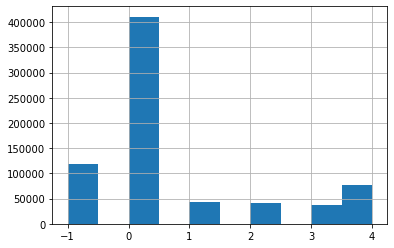

In [16]:
df_yy['ws_c'].hist()

<AxesSubplot:>

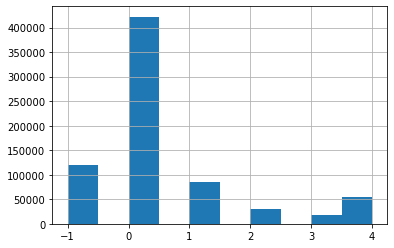

In [17]:
df_yy['wd_c'].hist()

<AxesSubplot:>

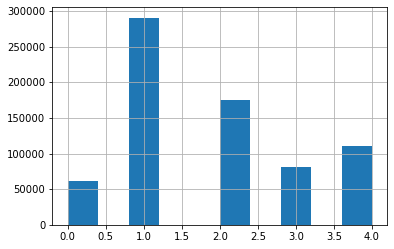

In [18]:
df_yy['iv_c'][df_yy['iv_c'] >= 0].hist()

<AxesSubplot:>

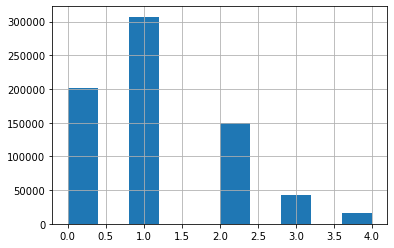

In [19]:
df_yy['sv_c'][df_yy['sv_c'] >= 0].hist()

In [23]:
# Save results in row format
df_yy.to_csv(inPATH('annual-exploded'))

In [24]:
# Read in monthly data created in step 2
df_ba = pd.read_csv(inPATH('annual-exploded'), index_col = ['pfaf_id', 'period'])
# Only using baseline monthly data. Drop all other years/scenarios
df_ba = df_ba[df_ba.scen == 'baseline_hist']
# Drop non-indicator data
simple_ind_cols = ['{}_{}'.format(i, s) for i in ['ws', 'wd', 'iv', 'sv'] for s in ['r', 's', 'c', 'l']]
df_ba= df_ba.filter(simple_ind_cols)
df_ba = df_ba.droplevel(level = ['period'])
# # Rename columns using Aqueduct naming structure. 
ind_cols = [baseline_inds.get(x[0:2]) + baseline_typs.get(x[2:]) for x in df_ba.columns]
df_ba.columns = ind_cols

In [25]:
df_ba.to_csv(fnPATH('annual'))

# 4. Turn GCMs into Scenario Summaries

In [9]:
def absolute_sd(ind):
    '''
    Goals:
    Convert value to flux (m) 
    Find level of uncertainity: calculate COV, then convert to score
    '''
    # Define indicator field names
    raw = ind
    # Filter by indicator 
    df_ind = stats[raw]
    # Add area to dataframe
    df_ind = pd.merge(df_ind.reset_index(), area2, how = 'left', left_on = 'pfaf_id', right_index = True).set_index(['pfaf_id', 'prefix'])
    # Calculate median FLUXES in cm
    # million m3 * 1 million / m2 = meters; meters * 100 cm/meter = cm
    df_ind['x_r'] = (df_ind['median'] * 1e6) /  df_ind['area_m2'] * 100 
    # Calculate Coefficient of Variation for indicators
    df_ind['cov'] = df_ind['std'].divide(df_ind['mean'])*100
    df_ind['cov'].replace(np.inf, 0, inplace = True)
    df_ind['cov'].replace(np.nan, 0, inplace = True)
    # Turn COV into score
    df_ind['x_u'] = df_ind['cov'].apply(lambda x: cov_score(x))
    # Fitler data, only keep min, max, med fluxes and COV score (uncertainity)
    df_ind = df_ind.filter(['x_r', 'x_u'])
    # Update columns names to include indicator
    df_ind = df_ind.add_prefix(raw + '_')
    return df_ind

def absolute_indicator(ind, scr_func, lab_dict):
    raw = ind + "_r"
    # Filter by indicator 
    df_ind = stats[raw]
    # Calculate Coefficient of Variation for indicators
    df_ind['cov'] = df_ind['std'].divide(df_ind['mean']) * 100
    df_ind['cov'].replace(np.inf, 0, inplace = True)
    df_ind['cov'].replace(np.nan, 0, inplace = True)
    # Turn COV into score
    df_ind['x_u'] = df_ind['cov'].apply(lambda x: cov_score(x))
    # Recalculate score, category and labels
    df_ind['x_r'] = df_ind['median']
    df_ind['x_s'] = df_ind['median'].apply(lambda x: scr_func(x))
    df_ind['x_c'] = category(score = 'x_s', df_in = df_ind)['cat']
    df_ind['x_l'] = df_ind['x_c'].map(lab_dict)
    # Filter data
    df_ind = df_ind.filter(['x_r', 'x_s', 'x_c', 'x_l', 'x_u'])
    # # Update columns names to include indicator
    df_ind = df_ind.add_prefix(ind + '_')
    return df_ind

## Absolute Values

In [10]:
# - STEP 1: READ AND CLEAN DATA
# Read in annual data created in step 2
df_a = pd.read_csv(inPATH('annual-exploded'), index_col = ['pfaf_id'])
# Remove GCM from SCEN for aggregation, convert to code (bau, opp, pes)
df_a['scen'] = df_a['scen'].apply(lambda x: ssp_code.get(x.split("_")[1]))
# Convert period to shorter version (decade: 30, 50, 80)
df_a['period'] = df_a['period'].apply(lambda x: str(x)[2:])
# Drop historic data
df_a = df_a[df_a['period'] != '19']
# Rename supply and demand columns
df_a.rename(columns = {'bcr-ba' : 'ba', 'bcr-ww' : 'ww'}, inplace = True)
# # Filter to only keep raw values. We will have to re-do score, cat and label based on median value
raws = ['ba', 'ww', 'ar'] + ['{}_r'.format(i) for i in ['ws', 'wd', 'iv', 'sv']]
df_f = df_a.filter(['scen', 'period'] + raws).reset_index()
# create a 'prefix' column that combines scenario and year (opt30, bau30, etc)
df_f['prefix']  = df_f['scen'] + df_f['period']
# - STEP 3: RUN STATISTICS ACROSS RAW VALUES PER SCENARIO/YEAR
# # Run statistics across scenarios
stats = df_f.groupby(['pfaf_id', 'prefix'])[raws].agg(['median', 'mean', 'std', 'sum'])

# - STEP 4: PROCESS SUPPLY AND DEMAND
# pull median, min, max, and coefficient of variation
df_ba = absolute_sd('ba')
df_ww = absolute_sd('ww')
df_sd = pd.concat([df_ba, df_ww], axis = 1)
# Add labels
df_ba['ba_x_l'] = df_ba['ba_x_r'].apply(lambda x: ba_labels(x))
df_ww['ww_x_l'] = df_ww['ww_x_r'].apply(lambda x: ww_labels(x))

# - STEP 5: PROCESS INDICATORS. RECALCUTE SCORE, CAT, and LABEL
df_ws = absolute_indicator(ind = 'ws', scr_func = ws_score, lab_dict = ws_fut_labels)
df_wd = absolute_indicator(ind = 'wd', scr_func = wd_score, lab_dict = wd_labels)
df_iv = absolute_indicator(ind = 'iv', scr_func = iv_score, lab_dict = iv_labels)
df_sv = absolute_indicator(ind = 'sv', scr_func = sv_score, lab_dict = sv_labels)

# - STEP 6: DEFINE ARID IN WATER STRESS AND WATER DEPLETION
# Define catchment as arid if 3+ GCMs are arid
fut_ar = stats['ar']['sum']
fut_ar = fut_ar.rename('ar')

# merge all data together
df_abs = pd.concat([df_ba, df_ww, df_ws, df_wd, df_iv, df_sv, fut_ar], axis = 1)
# When at least three GCMs are ARID & LOW WATER USE, set Raw value to 1
df_abs['ws_x_r'] = df_abs['ws_x_r'].mask(df_abs['ar'] >= 3, 1)
df_abs['wd_x_r'] = df_abs['wd_x_r'].mask(df_abs['ar'] >= 3, 1)
# When at least three GCMs are ARID & LOW WATER USE,Set Score value to 5
df_abs['ws_x_s'] = df_abs['ws_x_s'].mask(df_abs['ar'] >= 3, 5)
df_abs['wd_x_s'] = df_abs['wd_x_s'].mask(df_abs['ar'] >= 3, 5)
# When at least three GCMs are ARID & LOW WATER USE,Set Cat value to -1
df_abs['ws_x_c'] = df_abs['ws_x_c'].mask(df_abs['ar'] >= 3, -1)
df_abs['wd_x_c'] = df_abs['wd_x_c'].mask(df_abs['ar'] >= 3, -1)
# When at least three GCMs are ARID & LOW WATER USE,Set Label
df_abs['ws_x_l'] = df_abs['ws_x_l'].mask(df_abs['ar'] >= 3, 'Arid and low water use')
df_abs['wd_x_l'] = df_abs['wd_x_l'].mask(df_abs['ar'] >= 3, 'Arid and Low Water Use')
# Drop arid from table
df_abs.drop(['ar'], axis = 1, inplace = True)

# Melt data so indicators go from columns to rows
df_abs_melt = df_abs.melt(ignore_index = False).reset_index()
# Create final column names by combining prefix to indicator
df_abs_melt['column'] = df_abs_melt['prefix'] + "_" + df_abs_melt['variable'] 
# Pivot so scenario-year-indicator-types are columns and catchments are rows
df_abs_final = pd.pivot(data = df_abs_melt, index = 'pfaf_id', values = 'value', columns = 'column')

# Sort columns by indicator, scenario, year, data type
scens = ['bau', 'opt', 'pes']
years = ['30', '50', '80']
inds = ['ws', 'wd', 'iv', 'sv']
dtypes = ['r', 's', 'c', 'l', 'u']

sd_cols = ['{}{}_{}_x_{}'.format(s, y, i, t) for i in ['ba', 'ww'] for s in scens for y in years for t in ['r', 'l', 'u']]
abs_cols = ['{}{}_{}_x_{}'.format(s, y, i, t) for i in inds for s in scens for y in years for t in dtypes]
df_abs_final = df_abs_final.filter(sd_cols + abs_cols)

## Change from baseline

In [11]:
# - STEP 1: COPY CLEAN FUTURE DATA
# Read in new absolute data from step above (before column prefixes were merged with indicators)
df_fut = df_abs.reset_index()

# - STEP 2: READ IN CLEAN BASELINE DATA
# Read in annual data and select historic
df_a = pd.read_csv(inPATH('annual-exploded'), index_col = ['pfaf_id'])
# Keep historic data
df_a = df_a.loc[df_a['period'] == 2019]
# Filter
raws = ['bcr-ba', 'bcr-ww'] + ['{}_r'.format(i) for i in ['ws', 'wd', 'iv', 'sv']]
df_f = df_a.filter(raws).reset_index()

# Add flux supply and demand to table
df_hist = pd.merge(df_f, area2, how = 'left', left_on = 'pfaf_id', right_index = True)
df_hist['ba_hist'] = (df_hist['bcr-ba'] * 1e6) /  df_hist['area_m2'] * 100 
df_hist['ww_hist'] = (df_hist['bcr-ww'] * 1e6) /  df_hist['area_m2'] * 100 

# Merge historic data to each future row by PFAF_ID
df_merge = pd.merge(df_fut, df_hist, how = 'left', left_on = 'pfaf_id', right_on = 'pfaf_id').set_index(['pfaf_id', 'prefix'])

# Create supply and demand change
df_merge['ba_y_r'] = df_merge['ba_x_r'].divide(df_merge['ba_hist'])
df_merge['ba_y_s'] = df_merge['ba_y_r'].apply(lambda x: change_sd_score(x))
df_merge['ba_y_c'] = category(score = 'ba_y_s', df_in = df_merge)['cat']
df_merge['ba_y_l'] = df_merge['ba_y_c'].map(change_sd_labels)

df_merge['ww_y_r'] = df_merge['ww_x_r'].divide(df_merge['ww_hist'])
df_merge['ww_y_s'] = df_merge['ww_y_r'].apply(lambda x: change_sd_score(x))
df_merge['ww_y_c'] = category(score = 'ww_y_s', df_in = df_merge)['cat']
df_merge['ww_y_l'] = df_merge['ww_y_c'].map(change_sd_labels)

# Create water stress and depletion
df_merge['ws_y_r'] = df_merge['ws_x_r'].divide(df_merge['ws_r'])
df_merge['ws_y_s'] = df_merge['ws_y_r'].apply(lambda x: change_ws_score(x))
df_merge['ws_y_c'] = category(score = 'ws_y_s', df_in = df_merge)['cat']
df_merge['ws_y_l'] = df_merge['ws_y_c'].map(change_ws_labels)

df_merge['wd_y_r'] = df_merge['wd_x_r'].divide(df_merge['wd_r'])
df_merge['wd_y_s'] = df_merge['wd_y_r'].apply(lambda x: change_ws_score(x))
df_merge['wd_y_c'] = category(score = 'wd_y_s', df_in = df_merge)['cat']
df_merge['wd_y_l'] = df_merge['wd_y_c'].map(change_ws_labels)

# Cap any changes that occur within the same in extreme bands (low and extremely high) as near normal
df_merge.loc[(df_merge['ws_x_r']>= 0.8) & (df_merge['ws_r']>= 0.8), 'ws_y_c'] = 0
df_merge.loc[(df_merge['wd_x_r']>= 0.8) & (df_merge['wd_r']>= 0.8), 'wd_y_c'] = 0
df_merge.loc[((df_merge['ws_x_r'] < 0.1) & (df_merge['ws_x_r'] >0)) & ((df_merge['ws_r'] < 0.1) &(df_merge['ws_r'] >0)), 'ws_y_c'] = 0
df_merge.loc[((df_merge['wd_x_r'] < 0.1) & (df_merge['wd_x_r'] >0)) & ((df_merge['wd_r'] < 0.1) &(df_merge['wd_r'] >0)), 'ws_y_c'] = 0


df_merge.loc[(df_merge['ws_x_r']>= 0.8) & (df_merge['ws_r']>= 0.8), 'ws_y_l'] = 'Near normal'
df_merge.loc[(df_merge['wd_x_r']>= 0.8) & (df_merge['wd_r']>= 0.8), 'wd_y_l'] = 'Near normal'
df_merge.loc[((df_merge['ws_x_r'] < 0.1) & (df_merge['ws_x_r'] >0)) & ((df_merge['ws_r'] < 0.1) &(df_merge['ws_r'] >0)), 'ws_y_l'] = 'Near normal'
df_merge.loc[((df_merge['wd_x_r'] < 0.1) & (df_merge['wd_x_r'] >0)) & ((df_merge['wd_r'] < 0.1) &(df_merge['wd_r'] >0)), 'ws_y_l'] = 'Near normal'

# Create variability 
df_merge['iv_y_r'] = df_merge['iv_x_r'].divide(df_merge['iv_r'])
df_merge['iv_y_s'] = df_merge['iv_y_r'].apply(lambda x: change_va_score(x))
df_merge['iv_y_c'] = category(score = 'iv_y_s', df_in = df_merge)['cat']
df_merge['iv_y_l'] = df_merge['iv_y_c'].map(change_va_labels)

df_merge['sv_y_r'] = df_merge['sv_x_r'].divide(df_merge['sv_r'])
df_merge['sv_y_s'] = df_merge['sv_y_r'].apply(lambda x: change_va_score(x))
df_merge['sv_y_c'] = category(score = 'sv_y_s', df_in = df_merge)['cat']
df_merge['sv_y_l'] = df_merge['sv_y_c'].map(change_va_labels)

# If both new and raw = 0, set to near normal
# Category
df_merge.loc[(df_merge['ws_x_r']== 0) & (df_merge['ws_r']== 0), 'ws_y_c'] = 0
df_merge.loc[(df_merge['wd_x_r']== 0) & (df_merge['wd_r']== 0), 'ws_y_c'] = 0
df_merge.loc[(df_merge['iv_x_r']== 0) & (df_merge['iv_r']== 0), 'ws_y_c'] = 0
df_merge.loc[(df_merge['sv_x_r']== 0) & (df_merge['sv_r']== 0), 'ws_y_c'] = 0
# label
df_merge.loc[(df_merge['ws_x_r']== 0) & (df_merge['ws_r']== 0), 'ws_y_l'] = 'Near normal'
df_merge.loc[(df_merge['wd_x_r']== 0) & (df_merge['wd_r']== 0), 'ws_y_l'] = 'Near normal'
df_merge.loc[(df_merge['iv_x_r']== 0) & (df_merge['iv_r']== 0), 'ws_y_l'] = 'Near normal'
df_merge.loc[(df_merge['sv_x_r']== 0) & (df_merge['sv_r']== 0), 'ws_y_l'] = 'Near normal'

# df_merge.replace(np.inf, np.nan, inplace = True)

# Only keep labels
df_merge_f = df_merge.loc[:, [x for x in df_merge.columns if "_y_" in x]]

# Melt data so indicators go from columns to rows
df_chg_melt = df_merge_f.melt(ignore_index = False).reset_index()
# Create final column names by combining prefix to indicator
df_chg_melt['column'] = df_chg_melt['prefix'] + "_" + df_chg_melt['variable'] 
# Pivot so scenario-year-indicator-types are columns and catchments are rows
df_chg_final = pd.pivot(data = df_chg_melt, index = 'pfaf_id', values = 'value', columns = 'column')


In [29]:
df_chg_final.loc[(df_chg_final['bau50_ws_y_l'] == 'Near normal') & (df_chg_final['bau50_ws_y_c'] != 0), ['bau50_ws_y_r','bau50_ws_y_s', 'bau50_ws_y_c' , 'bau50_ws_y_l']]

column,bau50_ws_y_r,bau50_ws_y_s,bau50_ws_y_c,bau50_ws_y_l
pfaf_id,,,,


## Merge absolute to change and save

In [13]:
df_fut_all = pd.concat([df_abs_final, df_chg_final], axis = 1)
df_fut_all.to_csv(fnPATH('future'))

In [16]:
df_fut_all['bau30_ws_x_l'].unique()

array(['Extremely high (>80%)', 'Arid and low water use',
       'Low-medium (10-20%)', 'Low (<10%)', 'Medium-high (20-40%)',
       'High (40-80%)'], dtype=object)

In [17]:
inPATH('future')

'C:\\Users\\Samantha.Kuzma\\OneDrive - World Resources Institute\\Projections\\Final_Data\\Data\\Aqueduct40\\step3_calculate_indicators\\working\\Aqueduct40_indicators_future-additive.csv'

<AxesSubplot:>

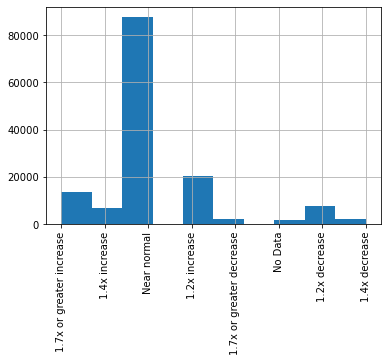

In [11]:
df_merge['ba_y_l'].hist(xrot=90)

<AxesSubplot:>

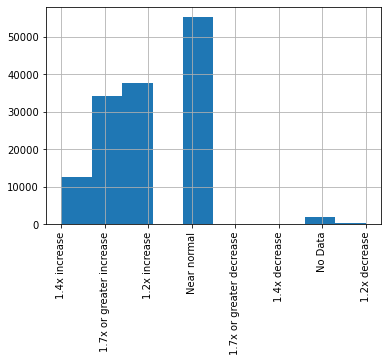

In [12]:
df_merge['ww_y_l'].hist(xrot=90)

<AxesSubplot:>

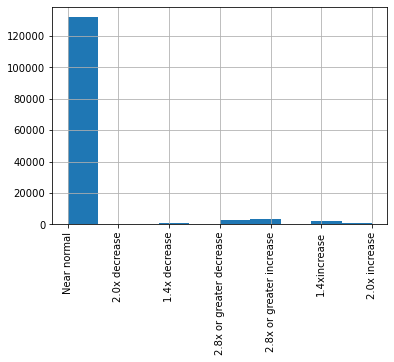

In [13]:
df_merge['ws_y_l'].hist(xrot=90)

<AxesSubplot:>

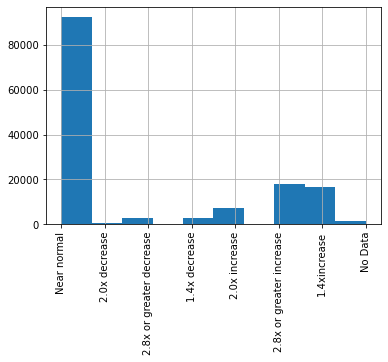

In [14]:
df_merge['wd_y_l'].hist(xrot=90)

<AxesSubplot:>

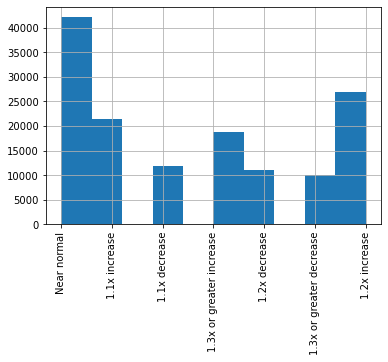

In [15]:
df_merge['iv_y_l'].hist(xrot=90)

<AxesSubplot:>

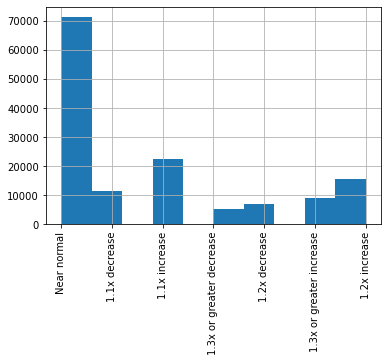

In [16]:
df_merge['sv_y_l'].hist(xrot=90)

# EXPERIMENT WITH FUTURE

In [38]:
df_m.loc[(155141, 2019),  'ws_r']

month  scen         
1      baseline_hist    5.832349e-09
2      baseline_hist    7.624134e-09
3      baseline_hist    1.093791e-08
4      baseline_hist    1.971535e-08
5      baseline_hist    4.345430e-08
6      baseline_hist    9.999000e+03
7      baseline_hist    9.999000e+03
8      baseline_hist    3.346112e-08
9      baseline_hist    2.281237e-08
10     baseline_hist    1.378896e-08
11     baseline_hist    9.796827e-09
12     baseline_hist    7.152080e-09
Name: ws_r, dtype: float64

In [ ]:
# Change categories. Same category = near normal
# Run Per GCM
# Use score to show change. score_new / score_old 
# Count how many increase vs how many decrease


In [118]:
# - STEP 1: COPY CLEAN FUTURE DATA
# Read in new absolute data from step above (before column prefixes were merged with indicators)
df_fut = df_abs.reset_index()

# - STEP 2: READ IN CLEAN BASELINE DATA
# Read in annual data and select historic
df_a = pd.read_csv(inPATH('annual-exploded'), index_col = ['period', 'pfaf_id', 'scen'])
# # Keep historic data
# df_a = df_a.loc[df_a['period'] == 2019]
# # Filter
# raws = ['bcr-ba', 'bcr-ww'] + ['{}_r'.format(i) for i in ['ws', 'wd', 'iv', 'sv']]
# df_f = df_a.filter(raws).reset_index()

# # Add flux supply and demand to table
# df_hist = pd.merge(df_f, area2, how = 'left', left_on = 'pfaf_id', right_index = True)
# df_hist['ba_hist'] = (df_hist['bcr-ba'] * 1e6) /  df_hist['area_m2'] * 100 
# df_hist['ww_hist'] = (df_hist['bcr-ww'] * 1e6) /  df_hist['area_m2'] * 100 

# # Merge historic data to each future row by PFAF_ID
# df_merge = pd.merge(df_fut, df_hist, how = 'left', left_on = 'pfaf_id', right_on = 'pfaf_id').set_index(['pfaf_id', 'prefix'])


In [152]:
# Read in historic raw data
df_hist = df_a.loc[2019, ['bcr-ba', 'bcr-ww'] + ['{}_s'.format(i) for i in ['ws', 'wd', 'iv', 'sv']]]
df_hist = df_hist.droplevel('scen')
# df_hist['ws_r'] = df_hist['ws_r'].mask(df_hist['ws_r'] < 0.001, 0) 
# Read in future raw data
df_30 = df_a.loc[2030, ['bcr-ba', 'bcr-ww'] + ['{}_s'.format(i) for i in ['ws', 'wd', 'iv', 'sv']]]
df_30 = df_30.reset_index().set_index('pfaf_id')
scens = df_30['scen'].tolist()
# Turn historic into baseline (ie historic value for each scenario)
df_base = pd.DataFrame(index = df_30.index, columns = df_30.columns, data = df_hist)
df_base['scen'] = scens
# Set index to include scenario again
df_30 = df_30.reset_index().set_index(['pfaf_id', 'scen'])
df_base = df_base.reset_index().set_index(['pfaf_id', 'scen'])

In [169]:
df_subtract = df_30.subtract(df_base)

In [193]:
# Find scores that changes categories
df_increase = df_subtract[df_subtract['ws_s'] > 0]
df_same = df_subtract[df_subtract['ws_s'] == 0]
df_decrease = df_subtract[df_subtract['ws_s'] < 0]

In [204]:
df_decrease

bcr-ba     bcr-ww      ws_s      wd_s  \
pfaf_id scen                                                              
111081  gfdl-esm4_ssp126       -8.516501  12.312033 -0.034544 -0.271197   
        gfdl-esm4_ssp585      -24.164519  13.969961 -0.074026 -0.628412   
        mpi-esm1-2-hr_ssp126  540.615269   4.090736 -0.280557 -2.399540   
        mpi-esm1-2-hr_ssp370  446.785992   3.284410 -0.072925 -2.164519   
        mpi-esm1-2-hr_ssp585  596.664730   9.604285 -0.018031 -1.600353   
...                                  ...        ...       ...       ...   
863014  mpi-esm1-2-hr_ssp585   15.195729   0.000000 -5.000000 -5.000000   
        mri-esm2-0_ssp126      22.625333   0.000000 -5.000000 -5.000000   
        mri-esm2-0_ssp370      12.905300   0.000000 -5.000000 -5.000000   
        mri-esm2-0_ssp585      33.494701   0.000000 -5.000000 -5.000000   
        ukesm1-0-ll_ssp585     10.803316   0.000000 -5.000000 -5.000000   

                                  iv_s      sv_s  
pfaf_id scen                                      
111081  gfdl-esm4_ssp126      1.158693 -0.227492  
        gfdl-esm4_ssp585      1.021512 -0.184344  
        mpi-esm1-2-hr_ssp126  0.094177 -0.586548  
        mpi-esm1-2-hr_ssp370  0.543724 -0.592348  
        mpi-esm1-2-hr_ssp585  1.158693 -0.168892  
...                                ...       ...  
863014  mpi-esm1-2-hr_ssp585  0.130137  0.158626  
        mri-esm2-0_ssp126     0.161819  0.274591  
        mri-esm2-0_ssp370     0.478004  0.247064  
        mri-esm2-0_ssp585     0.257187  0.406777  
        ukesm1-0-ll_ssp585    0.091732  0.072702  

[23981 rows x 6 columns]

In [235]:
def gcm_count(df, direction):
    df_count = df.reset_index()
    df_count['ssp'] = df_count['scen'].apply(lambda x: x.split("_")[1])
    df_gcm = df_count.groupby(['pfaf_id', 'ssp'])['ws_s'].count().to_frame(name = 'gcm_count')
    df_gcm['gcm_' + direction] = df_gcm['gcm_count']/5 * 100
    return df_gcm.filter(['gcm_' + direction])

In [236]:
def gcm_med(df):
    df_count = df.reset_index()
    df_count['ssp'] = df_count['scen'].apply(lambda x: x.split("_")[1])
    df_gcm = df_count.groupby(['pfaf_id', 'ssp'])['ws_s'].median().to_frame(name = 'median')
    return df_gcm.filter(['median'])

In [237]:
df_med = gcm_med(df_subtract)

In [242]:
df_stat = pd.concat([df_med, df_g], axis = 1)

In [249]:
def ws_change_cat(r):
    if r < -1:
        score = -2
    elif r < 0:
        score = -1
    elif r == 0:
        score =0
    elif r < 1:
        score = 1
    elif r >=1:
        score = 2
    return score

In [250]:
df_stat['ws_s'] = df_stat['median'].apply(lambda x: ws_change_cat(x))
df_stat['ws_u'] = np.nan

In [257]:
df_stat['ws_u'] = df_stat['ws_u'].mask(df_stat['ws_s'] < 0,  df_stat['gcm_decrease'])
df_stat['ws_u'] = df_stat['ws_u'].mask(df_stat['ws_s'] == 0,  df_stat['gcm_same'])
df_stat['ws_u'] = df_stat['ws_u'].mask(df_stat['ws_s'] > 0,  df_stat['gcm_increase'])

In [259]:
df_stat[df_stat['ws_s'] > 0]

median  gcm_increase  gcm_decrease  gcm_same  ws_s   ws_u
pfaf_id ssp                                                                
111081  ssp126  0.209049          60.0          40.0       0.0     1   60.0
        ssp370  0.193192          60.0          40.0       0.0     1   60.0
111094  ssp126  0.251468          60.0           0.0      40.0     1   60.0
        ssp585  0.240613          80.0           0.0      20.0     1   80.0
111096  ssp585  0.020546          60.0          40.0       0.0     1   60.0
...                  ...           ...           ...       ...   ...    ...
822944  ssp370  0.302036         100.0           0.0       0.0     1  100.0
        ssp585  0.450180         100.0           0.0       0.0     1  100.0
822946  ssp126  0.379700         100.0           0.0       0.0     1  100.0
        ssp370  0.280833         100.0           0.0       0.0     1  100.0
        ssp585  0.356397         100.0           0.0       0.0     1  100.0

[7823 rows x 6 columns]

,,median,gcm_increase,gcm_decrease,gcm_same,ws_s,ws_u
pfaf_id,ssp,,,,,,
111011,ssp370,0.0,0.0,0.0,100.0,0,100.0
111012,ssp370,0.0,0.0,0.0,100.0,0,100.0
111013,ssp370,0.0,0.0,0.0,100.0,0,100.0
111014,ssp370,0.0,0.0,0.0,100.0,0,100.0
111015,ssp370,0.0,0.0,0.0,100.0,0,100.0
...,...,...,...,...,...,...,...
863095,ssp370,0.0,0.0,0.0,100.0,0,100.0
863096,ssp370,0.0,0.0,0.0,100.0,0,100.0
863097,ssp370,0.0,0.0,0.0,100.0,0,100.0


In [261]:
df_stat.loc[df_stat.index.get_level_values('ssp') == 'ssp370'].to_csv('change.csv')

In [227]:
df_count = df_increase.reset_index()
df_count['ssp'] = df_count['scen'].apply(lambda x: x.split("_")[1])
df_gcm = df_count.groupby(['pfaf_id', 'ssp'])['ws_s'].count().to_frame(name = 'gcm_count')
df_gcm['gcm_' + 'increase'] = df_gcm['gcm_count']/5 * 100

In [228]:
df_gcm

gcm_count  gcm_increase
pfaf_id ssp                            
111081  ssp126          3          60.0
        ssp370          3          60.0
        ssp585          2          40.0
111083  ssp126          1          20.0
        ssp370          1          20.0
...                   ...           ...
832449  ssp370          1          20.0
832802  ssp126          2          40.0
        ssp370          1          20.0
842032  ssp585          1          20.0
842033  ssp585          1          20.0

[12023 rows x 2 columns]

In [220]:
df_i = gcm_count(df_increase, 'increase')
df_s = gcm_count(df_same, 'same')
df_d = gcm_count(df_decrease, 'decrease')
df_g = pd.merge(df_i, df_d, how = 'outer', right_index = True, left_index = True)
df_g = pd.merge(df_g, df_s, how = 'outer', right_index = True, left_index = True)
df_g = df_g.fillna(0)

In [224]:
df_subtract

bcr-ba     bcr-ww  ws_s          wd_s  \
pfaf_id scen                                                             
111011  gfdl-esm4_ssp126       0.003691  26.458530   0.0  0.000000e+00   
        gfdl-esm4_ssp370       0.001272  28.944479   0.0  0.000000e+00   
        gfdl-esm4_ssp585       0.000128  27.051264   0.0  0.000000e+00   
        ipsl-cm6a-lr_ssp126    0.002845  26.699016   0.0  0.000000e+00   
        ipsl-cm6a-lr_ssp370    0.001791  29.069415   0.0  0.000000e+00   
...                                 ...        ...   ...           ...   
863099  mri-esm2-0_ssp370    423.562417   0.000084   0.0  2.012661e-07   
        mri-esm2-0_ssp585    826.394314   0.000084   0.0  6.491988e-08   
        ukesm1-0-ll_ssp126    43.600432   0.000084   0.0  4.217737e-07   
        ukesm1-0-ll_ssp370   -23.912379   0.000084   0.0  4.465275e-07   
        ukesm1-0-ll_ssp585   -24.298522   0.000084   0.0  4.485451e-07   

                                 iv_s      sv_s  
pfaf_id scen                                     
111011  gfdl-esm4_ssp126     0.000000  0.012080  
        gfdl-esm4_ssp370    -0.428584  0.317613  
        gfdl-esm4_ssp585     0.000000 -0.019307  
        ipsl-cm6a-lr_ssp126  0.000000  0.205145  
        ipsl-cm6a-lr_ssp370  0.000000 -0.479375  
...                               ...       ...  
863099  mri-esm2-0_ssp370   -0.014987  0.076743  
        mri-esm2-0_ssp585    0.101285  0.150547  
        ukesm1-0-ll_ssp126   0.296607 -0.187708  
        ukesm1-0-ll_ssp370   0.368248 -0.210244  
        ukesm1-0-ll_ssp585   0.092443 -0.136807  

[237495 rows x 6 columns]

In [131]:
df_all = pd.concat([df_base.add_suffix("_bs"), df_30.add_suffix("_ft"), df_change.add_suffix("_ch")], axis = 1)

In [132]:
# If both current and future WS = 0; change = 1
df_all['ws_r_ch'] = df_all['ws_r_ch'].mask((df_all['ws_r_bs'] == 0) & (df_all['ws_r_ft'] > 0), 1) 
df_all['ws_r_ch'] = df_all['ws_r_ch'].mask((df_all['ws_r_bs'] == 0) & (df_all['ws_r_ft'] > 0), 9999 ) 

In [133]:
df_all['ws_r_ch'][(df_all['ws_r_bs'] == 0) & (df_all['ws_r_ft'] > 0)].unique()

array([9999.])

In [135]:
df_all[df_all['ws_r_ch'] >= 999]

bcr-ba_bs   bcr-ww_bs   ws_r_bs   wd_r_bs  \
pfaf_id scen                                                                
111081  mri-esm2-0_ssp585      539.876362  180.485446  1.341689  0.927000   
111083  mri-esm2-0_ssp585      561.315348    0.757086  0.004113  0.004113   
111087  gfdl-esm4_ssp370       307.717569    8.978616  1.000000  1.000000   
        ipsl-cm6a-lr_ssp126    307.717569    8.978616  1.000000  1.000000   
        ipsl-cm6a-lr_ssp370    307.717569    8.978616  1.000000  1.000000   
...                                   ...         ...       ...       ...   
832802  gfdl-esm4_ssp126      1392.182018    0.100985  0.000121  0.000082   
        mpi-esm1-2-hr_ssp126  1392.182018    0.100985  0.000121  0.000082   
        mpi-esm1-2-hr_ssp370  1392.182018    0.100985  0.000121  0.000082   
842032  mpi-esm1-2-hr_ssp585   114.720947    0.003201  0.000042  0.000039   
842033  mpi-esm1-2-hr_ssp585    31.765001    0.000000  0.000000  0.000000   

                               iv_r_bs   sv_r_bs    bcr-ba_ft   bcr-ww_ft  \
pfaf_id scen                                                                
111081  mri-esm2-0_ssp585     0.960327  1.314690   370.724277  197.891188   
111083  mri-esm2-0_ssp585     0.842368  1.278207   320.290342    4.186474   
111087  gfdl-esm4_ssp370      0.657091  1.303496   455.705115   13.021163   
        ipsl-cm6a-lr_ssp126   0.657091  1.303496   455.983812   13.492526   
        ipsl-cm6a-lr_ssp370   0.657091  1.303496   366.159436   12.549264   
...                                ...       ...          ...         ...   
832802  gfdl-esm4_ssp126      1.540448  0.974883  1650.435794    0.114700   
        mpi-esm1-2-hr_ssp126  1.540448  0.974883   951.016854    0.114700   
        mpi-esm1-2-hr_ssp370  1.540448  0.974883   488.969665    0.114700   
842032  mpi-esm1-2-hr_ssp585  0.750456  0.804244   103.898946    0.003652   
842033  mpi-esm1-2-hr_ssp585  0.783545  0.819236    28.264304    0.000000   

                                  ws_r_ft      wd_r_ft   iv_r_ft   sv_r_ft  \
pfaf_id scen                                                                 
111081  mri-esm2-0_ssp585     9999.000000  9999.000000  1.206667  1.029849   
111083  mri-esm2-0_ssp585     9999.000000  9999.000000  1.085921  1.017508   
111087  gfdl-esm4_ssp370      9999.000000  9999.000000  1.226809  1.166469   
        ipsl-cm6a-lr_ssp126   9999.000000  9999.000000  0.656686  1.079129   
        ipsl-cm6a-lr_ssp370   9999.000000  9999.000000  0.705942  1.059344   
...                                   ...          ...       ...       ...   
832802  gfdl-esm4_ssp126         0.161007     0.160992  0.840635  1.004763   
        mpi-esm1-2-hr_ssp126     0.487003     0.486995  0.850171  0.851218   
        mpi-esm1-2-hr_ssp370     1.000000     1.000000  1.035091  0.859838   
842032  mpi-esm1-2-hr_ssp585     0.168645     0.168632  0.687469  0.828143   
842033  mpi-esm1-2-hr_ssp585     1.000000     1.000000  0.723644  0.855654   

                              bcr-ba_ch  bcr-ww_ch       ws_r_ch  \
pfaf_id scen                                                       
111081  mri-esm2-0_ssp585      0.686684   1.096438  7.452548e+03   
111083  mri-esm2-0_ssp585      0.570607   5.529721  2.430933e+06   
111087  gfdl-esm4_ssp370       1.480920   1.450242  9.999000e+03   
        ipsl-cm6a-lr_ssp126    1.481826   1.502740  9.999000e+03   
        ipsl-cm6a-lr_ssp370    1.189920   1.397684  9.999000e+03   
...                                 ...        ...           ...   
832802  gfdl-esm4_ssp126       1.185503   1.135816  1.331115e+03   
        mpi-esm1-2-hr_ssp126   0.683112   1.135816  4.026249e+03   
        mpi-esm1-2-hr_ssp370   0.351225   1.135816  8.267410e+03   
842032  mpi-esm1-2-hr_ssp585   0.905667   1.140839  4.020416e+03   
842033  mpi-esm1-2-hr_ssp585   0.889794        NaN  9.999000e+03   

                                   wd_r_ch   iv_r_ch   sv_r_ch  
pfaf_id scen                                                   

In [136]:
df_all.to_csv('all.csv')

In [98]:
df_all[[x for x in df_all.columns if "ws" in x]].sort_values(by = 'ws_r_ch', ascending = False)

ws_r_bs      ws_r_ft       ws_r_ch
pfaf_id scen                                                         
351362  ipsl-cm6a-lr_ssp370   6.917961e-11  9999.000000  1.445368e+14
331724  ipsl-cm6a-lr_ssp585   8.629812e-08  9999.000000  1.158658e+11
351366  mpi-esm1-2-hr_ssp126  1.365656e-07  9999.000000  7.321758e+10
351362  mpi-esm1-2-hr_ssp126  6.917961e-11     1.000000  1.445513e+10
        ipsl-cm6a-lr_ssp126   6.917961e-11     0.777333  1.123645e+10
...                                    ...          ...           ...
863014  gfdl-esm4_ssp126      1.000000e+00     0.000000  0.000000e+00
545000  gfdl-esm4_ssp585      1.000000e+00     0.000000  0.000000e+00
155570  ipsl-cm6a-lr_ssp370   1.000000e+00     0.000000  0.000000e+00
331740  ukesm1-0-ll_ssp585    1.000000e+00     0.000000  0.000000e+00
831509  gfdl-esm4_ssp585      1.000000e+00     0.000000  0.000000e+00

[237495 rows x 3 columns]

In [99]:
df_all.sort_values(by = 'ws_r_ch', ascending = False)

bcr-ba_bs     bcr-ww_bs       ws_r_bs  \
pfaf_id scen                                                           
351362  ipsl-cm6a-lr_ssp370   207.456691  7.782294e-09  6.917961e-11   
331724  ipsl-cm6a-lr_ssp585   102.674763  4.777477e-06  8.629812e-08   
351366  mpi-esm1-2-hr_ssp126  294.818854  1.859041e-05  1.365656e-07   
351362  mpi-esm1-2-hr_ssp126  207.456691  7.782294e-09  6.917961e-11   
        ipsl-cm6a-lr_ssp126   207.456691  7.782294e-09  6.917961e-11   
...                                  ...           ...           ...   
863014  gfdl-esm4_ssp126       63.795505  0.000000e+00  1.000000e+00   
545000  gfdl-esm4_ssp585       35.771557  0.000000e+00  1.000000e+00   
155570  ipsl-cm6a-lr_ssp370     0.001191  0.000000e+00  1.000000e+00   
331740  ukesm1-0-ll_ssp585    219.530084  0.000000e+00  1.000000e+00   
831509  gfdl-esm4_ssp585       29.236985  0.000000e+00  1.000000e+00   

                                   wd_r_bs   iv_r_bs   sv_r_bs   bcr-ba_ft  \
pfaf_id scen                                                                 
351362  ipsl-cm6a-lr_ssp370   6.917961e-11  0.899485  1.156894  141.688175   
331724  ipsl-cm6a-lr_ssp585   8.629812e-08  0.832105  0.979292   70.483418   
351366  mpi-esm1-2-hr_ssp126  1.365656e-07  1.044171  1.183728  194.553948   
351362  mpi-esm1-2-hr_ssp126  6.917961e-11  0.899485  1.156894   78.483945   
        ipsl-cm6a-lr_ssp126   6.917961e-11  0.899485  1.156894  132.717392   
...                                    ...       ...       ...         ...   
863014  gfdl-esm4_ssp126      1.000000e+00  0.299864  0.350650   83.790334   
545000  gfdl-esm4_ssp585      1.000000e+00  1.388119  0.465745   83.681476   
155570  ipsl-cm6a-lr_ssp370   1.000000e+00  6.403124  2.292900   14.408119   
331740  ukesm1-0-ll_ssp585    1.000000e+00  0.971884  1.077061  612.706145   
831509  gfdl-esm4_ssp585      1.000000e+00  0.766285  0.765838   49.229714   

                                 bcr-ww_ft      ws_r_ft      wd_r_ft  \
pfaf_id scen                                                           
351362  ipsl-cm6a-lr_ssp370   8.144437e-09  9999.000000  9999.000000   
331724  ipsl-cm6a-lr_ssp585   5.987815e-06  9999.000000  9999.000000   
351366  mpi-esm1-2-hr_ssp126  1.838265e-05  9999.000000  9999.000000   
351362  mpi-esm1-2-hr_ssp126  8.144437e-09     1.000000     1.000000   
        ipsl-cm6a-lr_ssp126   8.144437e-09     0.777333     0.777333   
...                                    ...          ...          ...   
863014  gfdl-esm4_ssp126      0.000000e+00     0.000000     0.000000   
545000  gfdl-esm4_ssp585      0.000000e+00     0.000000     0.000000   
155570  ipsl-cm6a-lr_ssp370   0.000000e+00     0.000000     0.000000   
331740  ukesm1-0-ll_ssp585    0.000000e+00     0.000000     0.000000   
831509  gfdl-esm4_ssp585      0.000000e+00     0.000000     0.000000   

                               iv_r_ft   sv_r_ft     bcr-ba_ch  bcr-ww_ch  \
pfaf_id scen                                                                
351362  ipsl-cm6a-lr_ssp370   0.817849  1.442362      0.682977   1.046534   
331724  ipsl-cm6a-lr_ssp585   0.928193  1.279877      0.686473   1.253342   
351366  mpi-esm1-2-hr_ssp126  1.012899  1.530156      0.659910   0.988824   
351362  mpi-esm1-2-hr_ssp126  1.215960  1.415084      0.378315   1.046534   
        ipsl-cm6a-lr_ssp126   1.078329  1.514423      0.639735   1.046534   
...                                ...       ...           ...        ...   
863014  gfdl-esm4_ssp126      0.297785  0.370461      1.313421        NaN   
545000  gfdl-esm4_ssp585      1.757731  0.449644      2.339330        NaN   
155570  ipsl-cm6a-lr_ssp370   1.567838  0.268508  12096.637284        NaN   
331740  ukesm1-0-ll_ssp585    0.792398  1.147303      2.790989        NaN   
831509  gfdl-esm4_ssp585      0.788516  0.776904      1.683816        NaN   

                                   ws_r_ch       wd_r_ch   iv_r_ch   sv_r_ch  
pfaf_id scen                                                 

In [58]:
df_base['bcr-ba'] = df_hist['bcr-ba'] 

In [60]:
pd.DataFrame(index = df_30.index, columns = df_30.columns, data = df_hist)

,scen,bcr-ba,bcr-ww,ws_r,wd_r,iv_r,sv_r
pfaf_id,,,,,,,
111011,NaN,0.009873,60.803346,9.999000e+03,9.999000e+03,1.421565,1.064935
111011,NaN,0.009873,60.803346,9.999000e+03,9.999000e+03,1.421565,1.064935
111011,NaN,0.009873,60.803346,9.999000e+03,9.999000e+03,1.421565,1.064935
111011,NaN,0.009873,60.803346,9.999000e+03,9.999000e+03,1.421565,1.064935
111011,NaN,0.009873,60.803346,9.999000e+03,9.999000e+03,1.421565,1.064935
...,...,...,...,...,...,...,...
863099,NaN,2045.401831,0.000634,3.805015e-07,5.493944e-08,0.232743,0.547860
863099,NaN,2045.401831,0.000634,3.805015e-07,5.493944e-08,0.232743,0.547860
863099,NaN,2045.401831,0.000634,3.805015e-07,5.493944e-08,0.232743,0.547860


### future

In [268]:
# Read in monthly data created in step 2
df_f = pd.read_csv(inPATH('future'), index_col = ['pfaf_id'])
df_f.drop(no_data_pfafs, inplace = True)
# Merge to spatial data (which will have more catchments than we had data for)
df_gbf = pd.merge(hy6, df_f, how = 'left', left_index = True, right_index = True)
# Set No Data as -9999
df_gbf.replace(np.nan, -9999, inplace = True)
# Relabel No Datas
for l in [x for x in df_gbf.columns if "_l" in x]:
    df_gbf[l].replace(-9999, 'No Data', inplace = True)

In [269]:
# Save CSV and Geodatabase version
df_fm_final = df_gbf.drop(['geometry'], axis = 1).sort_index()
df_fm_final.to_csv(fnPATH('future'))

In [270]:
df_fm_final[(df_fm_final['bau30_ws_y_c'] == -9999) & (df_fm_final['bau30_ws_y_l'] == 'Near normal')]

,bau30_ws_x_r,bau30_ws_x_s,bau30_ws_x_c,bau30_ws_x_l,bau30_ws_x_u,bau50_ws_x_r,bau50_ws_x_s,bau50_ws_x_c,bau50_ws_x_l,bau50_ws_x_u,...,pes80_wd_y_r,pes80_wd_y_s,pes80_ws_y_c,pes80_ws_y_l,pes80_ws_y_r,pes80_ws_y_s,pes80_ww_y_c,pes80_ww_y_l,pes80_ww_y_r,pes80_ww_y_s
pfaf_id,,,,,,,,,,,,,,,,,,,,,


In [220]:
df_merge.loc[132861, ['ws_x_r', 'ws_r']]

,ws_x_r,ws_r
prefix,,
bau30,0.0,0.0
bau50,0.0,0.0
bau80,0.0,0.0
opt30,0.0,0.0
opt50,0.0,0.0
opt80,0.0,0.0
pes30,0.0,0.0
pes50,0.0,0.0
pes80,0.0,0.0


In [215]:
inds = ['ws', 'wd', 'iv', 'sv']
years = ['30']
scens = ['bau']

for i in inds:
    for s in scens:
        for y in years:
            la = '{}{}_{}_y_l'.format(s,y,i)
            ra = '{}{}_{}_y_r'.format(s,y,i)
            sc = '{}{}_{}_y_s'.format(s,y,i)
            ca = '{}{}_{}_y_c'.format(s,y,i)
            df = df_fm_final.groupby(la)[ra, sc, ca].agg(['min', 'max'])
            print(df)

                         bau30_ws_y_r               bau30_ws_y_s          \
                                  min           max          min     max   
bau30_ws_y_l                                                               
1.4x or greater decrease     0.500218  7.060685e-01         -1.0    -1.0   
1.4x or greater increase     1.414324  1.988373e+00          1.0     1.0   
2.0x or greater decrease     0.353562  4.998989e-01         -2.0    -2.0   
2.0x or greater increase     2.000810  2.807793e+00          2.0     2.0   
2.8x or greater decrease     0.000000  3.503950e-01         -3.0    -3.0   
2.8x or greater increase     2.831607  4.472011e+09          3.0     3.0   
Near normal              -9999.000000  1.237322e+04      -9999.0     3.0   
No Data                  -9999.000000 -9.999000e+03      -9999.0 -9999.0   

                         bau30_ws_y_c          
                                  min     max  
bau30_ws_y_l                                   
1.4x or greater dec

# Explore

In [13]:
df_bm = pd.read_csv(fnPATH('monthly'), index_col = ['pfaf_id'])
df_bmx = df_bm[df_bm['bws_01_raw'] > 1]
df_mb = df_m[(df_m.index.get_level_values('period') == 2019) &  (df_m.index.get_level_values('month') == 1)]
df_mb = df_mb.droplevel(['period', 'month', 'scen'])

In [34]:
df_c = pd.merge(df_bmx.filter(['bws_01_raw', 'bws_01_label']), df_mb, how = 'left', left_index = True, right_index = True).sort_values(by = 'bws_01_raw', ascending = False)

In [35]:
df_c.to_csv('small_ba.csv')